<a href="https://colab.research.google.com/github/akamalas5/Capstone/blob/main/term_extraction_threshold_determination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Entity Relationship Extraction - Data, Model and Prediction**

### Import utility libraries

In [ ]:
import requests
from collections import defaultdict
from tqdm import tqdm
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import ast
import csv

# URL page extraction and annotation
import urllib
from string import punctuation
import nltk
import json
import itertools

Generate Sentenses from Corefererence Resolved Requirements Text paragraphs

In [ ]:
input_file = '../data/wiki_brake_all_pages_with_coref_df.csv'
rqt_df = pd.read_csv(input_file)
rqt_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'wiki_text', 'text_clean',
       'tex_coref_resolved'],
      dtype='object')

In [ ]:
def sentences(text):
    # split sentences and questions
    text = re.split('[.?]', str(text))
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

# sentences - The coref resolved data from offline is used
rqt_df['sent'] = rqt_df['tex_coref_resolved'].apply(sentences)
print("Number of requirements :", len(rqt_df))
rqt_df = rqt_df.dropna().reset_index(drop=True)
rqt_df.head(3)

Number of requirements : 2877


,Unnamed: 0,Unnamed: 0.1,wiki_text,text_clean,tex_coref_resolved,sent
0,0,0,A brake is a mechanical device that inhibits m...,A brake is a mechanical device that inhibits m...,A brake is a mechanical device that inhibits m...,[A brake is a mechanical device that inhibits ...
1,1,1,Most brakes commonly use friction between two ...,Most brakes commonly use friction between two ...,Most brakes commonly use friction between two ...,[Most brakes commonly use friction between two...
2,2,2,Brakes are generally applied to rotating axles...,Brakes are generally applied to rotating axles...,Brakes are generally applied to rotating axles...,[Brakes are generally applied to rotating axle...


Create a dataframe of just sentences alone




In [ ]:
rqt_df2 = pd.DataFrame(columns=['Sent','Len'])

row_list = []

for i in range(len(rqt_df)):
    for sent in rqt_df.loc[i,'sent']:
        wordcount = len(sent.split())
        if wordcount>0:
            dict1 = {'Sent':sent.strip(),'Len':wordcount}
            row_list.append(dict1)
    
rqt_df2 = pd.DataFrame(row_list)
print("The number of sentenses Generated :", len(rqt_df2))
rqt_df2.head(5)

The number of sentenses Generated : 9569


,Sent,Len
0,A brake is a mechanical device that inhibits m...,16
1,A brake is used for slowing or stopping a movi...,26
2,Most brakes commonly use friction between two ...,30
3,"For example, regenerative braking converts muc...",19
4,Other methods convert kinetic energy into pote...,18


**Extracting Entities using Wikifier Annotations**

### Get Annotations - Terms, Words, Tokens, postions

The threshold value determines the number of terms extracted (based on page rank score).  The higher the threshold more will be the number of terms extracted.  Trials are conducted with the threshold values of 0.6, 0.7, 0.8 , 0.9 and 1.0. The extracted terms/entities are compared with the terms/entities extracted mannually and accuracy socre is computed.  The accuracy obtained for the threshold value of 0.8 is found to be maximum and became the ideal threshold value for this study

In [ ]:
def CallWikifier_1(text, lang="en", threshold=1.0):
    # Prepare the URL.
    result = []
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "hnjbhmqwsejlhzzjhlqtyybolxgpgs"),   
        ("pageRankSqThreshold", "%g" % threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "200"), ("nWordsToIgnoreFromList", "200"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
        ])

    url = "http://www.wikifier.org/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    
    with urllib.request.urlopen(req, timeout = 60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    tokens = response['words']
    for annotation in response["annotations"]:
        word_indexs = [(el['wFrom'], el['wTo']+1) for el in annotation['support']]
        words = [tokens[el['wFrom']:el['wTo']+1] for el in annotation['support']]
        longword = " ".join(max(words, key=len))
        ind = words.index(max(words, key=len))
        longwrod_ind = [word_indexs[ind][0], word_indexs[ind][1]]

        if 'wikiDataItemId' in annotation:
          result.append({'term': {"name": longword, 'entity':annotation["title"], 'id' :annotation['wikiDataItemId'],  
                                  "pos": longwrod_ind }})
        else :
          result.append({'term': {"name": longword, 'entity':annotation["title"], 'id' :"no_id", 
                                  "pos": longwrod_ind}})

    result.append({"token":tokens})

    
    return result

### Extaract the all Combinations of Source /Target Pairs

Form the extracted terms for a sentences, all permuatationon of pairing (source and target ) computed for link prediction

In [ ]:
def create_map_data(input_df, threshold = 1):
  train_data = []
  for input_sent in tqdm(input_df["Sent"]):
    result = CallWikifier_1(input_sent, threshold = threshold)
    terms = [item for item  in result if ('term' in item)]
    token_dict = [item for item  in result if ('token' in item)]
    token = token_dict[0]['token']
    
    for permutation in itertools.permutations(terms, 2):
      train_data.append({'data' : {'token' :token, 'h': permutation[0]['term'], 't': permutation[1]['term'], 
                                   "relation" : "owned by"},
                          'source_word':permutation[0]['term']['name'],
                          'target_word':permutation[1]['term']['name'],
                          'source_term':permutation[0]['term']['entity'],
                          'target_term':permutation[1]['term']['entity'] })
    
  return pd.DataFrame(train_data) 

The terms extraction is time consuming. So the input data is split into chucks and processed. The data processed for each chuck is persisted as csv file.  This enables fail over mechanism to begin from where it ended from the last run.  Once the all input chuks are processed, the corresponding .csv files are combined. The code for exeuction of the funtion is commented. The output file is provided readily to continue to the next steps

In [ ]:
def create_map(input_df, num_chunks = 10, threshold = 0.8, iterid = 0, suffix ="brake_"):
  input_dfs = np.array_split(input_df, num_chunks)
  for idx, df in enumerate(input_dfs): 
    df_name = suffix+str(iterid)+"_"+str(threshold)+"_"+str(idx)
    map_df = create_map_data(df, threshold = threshold)
    print(len(map_df))
    output_file = "../data/"+df_name+".csv"
    map_df.to_csv(output_file, header = True, index = False)
    return output_file

num_chunks = 10
threshold = 0.6
iterid = 0
suffix = "dec12_req_map_"
#create_map(rqt_df2, num_chunks =num_chunks, threshold = threshold, iterid = iterid, suffix =suffix )

Combine the CSV files generated for chucks of data and genrate Final mapping File  - The final output file is provided in the data Folder - dec_07_mapping_data_wiki_text_0.8.csv

In [ ]:
import glob, os
output_dir = "../data/"
output_name = "dec_07_mapping_data_wiki_text_0.8.csv"
os.chdir(output_dir)
list_of_dfs = list()
# for file in glob.glob("*.csv"):
#   df = pd.read_csv(file)
  #print(len(df))
  #list_of_dfs.append(df)
#df = pd.concat(list_of_dfs)
#print(len(df))
# df.to_csv(output_name)

### Ideal Threshold Value Determination for Terms Extraction


*   Extract random 100 samples from the input data
*   Annotate terms of the sample sentenses
*   Normalize the wikifier extracted terms and compare with manual annodation
*   Compute the precisions for the terms extracted with the threshold values of 0.6, 07, 0.9=8, 0.9 and 1.0
*   Determine the best threshold value and use them for terms extraction



In [ ]:
# The input text is annotated using Wifikier API and terms are extracted
def Wikified_terms(text, lang="en", threshold=1):
    # Prepare the URL.
    result = []
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "hnjbhmqwsejlhzzjhlqtyybolxgpgs"),   #sbasarkoumichedu
        
        ("pageRankSqThreshold", "%g" % threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "200"), ("nWordsToIgnoreFromList", "200"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
        ])

    url = "http://www.wikifier.org/annotate-article"
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    
    with urllib.request.urlopen(req, timeout = 60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))

    # Output the annotations.
    terms = []
    for annotation in response["annotations"]:
        if 'wikiDataItemId' in annotation:
          terms.append(annotation["title"])
        else :
          terms.append(annotation["title"])

    return terms    

In [ ]:
# The output files generated with different thresholds numbers
input_files = ['dec_12_mapping_data_wiki_text_0.6.csv',
               'dec_12_mapping_data_wiki_text_0.7.csv',
               'dec_07_mapping_data_wiki_text_0.8.csv',
               'dec_12_mapping_data_wiki_text_0.9.csv',
               'dec_12_mapping_data_wiki_text_1.0.csv']

data_dir = "../data/"
# for file in input_files:
#   input_file = data_dir + file
#   df = pd.read_csv(input_file)
#   df['data'] = df['data'].apply(ast.literal_eval)
#   df['tokens'] = df['data'].apply(lambda x: x.pop("token", None))
#   df['liststring'] = [' '.join(map(str, l)) for l in df['tokens']]
#   print("Input Dataframe length :", len(df))
#   df = df.groupby('liststring').agg({'source_term': ','.join, 'source_word':'.'.join})
#   print("Dataframe sentenses length :", len(df))
#   df.to_csv(data_dir+"terms"+file)

Calculate Precission Score

Generate Output with Sample sentenses extracted from the wiki documents. Refer the Final output file in the data Folder - wiki_mapping/wiki_entities_baseline.csv. If you want to generate the outfile, please uncomment the code below.

In [ ]:
base_line = "wiki_entities_baseline.csv"
data_dir = "../data/"
input_df = pd.read_csv(data_dir+base_line)
print("length of input df :", len(input_df))
thresh_holds = [0.6, 0.7, 0.8, 0.9, 1.0]

# Uncomment the following line if you want to generate the output file (Also available in the data folder)

# for threhold in thresh_holds:
#   input_df['terms_'+str(threhold)] = input_df['Sent'].apply(lambda x: Wikified_terms(x, threshold=threhold) )
# output_file = "wiki_entities_baseline_threshold_terms.csv"
# input_df.to_csv(data_dir+output_file)

length of input df : 91


In [ ]:
input_df.head()

,Unnamed: 0,Sent,Len,wiki_entities,Manual Annotation
0,0,A brake is a mechanical device that inhibits m...,16,"['Brake', 'Machine', 'Motion', 'Absorption (el...","Brake, Machine, energy, system"
1,1,A brake is used for slowing or stopping a movi...,26,"['Brake', 'Motion', 'Vehicle', 'Wheel', 'Axle'...","Brake, Moving Vehicle, Wheel, Axle, Motion, Fr..."
2,2,Most brakes commonly use friction between two ...,30,"['Most (city)', 'Brake', 'Common name', 'Frict...","Brake, Friction, Surface, Pressure, Kinetic En..."
3,3,"For example, regenerative braking converts muc...",19,"['For', '.example', 'Regenerative brake', 'Bra...","Regenerative Brake, Energy, Electrical Energy"
4,4,Other methods convert kinetic energy into pote...,18,"['Scientific method', 'Kinetic energy', 'Poten...","Kinetic Energy, Potential Energy, compressed a..."


## Calcualte accruracy of Terms extracted
Compare the terms extracted manually against the terms extracted with threshold values of - 0.6, 0.7, 0.8, 0.9 and 1.0 and compare

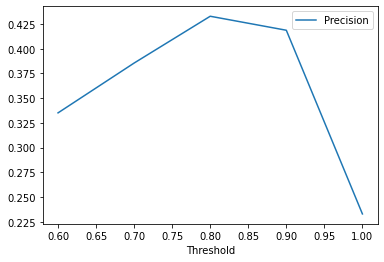

In [ ]:
import re

data_dir = "../data/"
input_df =  "wiki_entities_baseline_threshold_terms.csv"
input_df = pd.read_csv(data_dir+input_df)

mean_precision = dict()
thresh_holds = [0.6, 0.7, 0.8, 0.9, 1.0]
for threhold in thresh_holds:
  metric = []
  for index, row in input_df.iterrows():    
      wiki_ents = (re.sub("[\[\]\']",'', str(row['terms_'+str(threhold)]))).split(',')
      wiki_ents = [ent.strip().lower() for ent in wiki_ents]
      
      manl_ants = (re.sub("[\[\]\']",'', str(row['Manual Annotation']))).split(',')
      manl_ants = [ent.strip().lower() for ent in manl_ants if len(ent.strip())>0]
        
      overlap = [wiki_ents[i] for i in range(len(wiki_ents)) if wiki_ents[i] in manl_ants ]
      tpr = len(overlap)
      tpr_fpr = len(wiki_ents) if len(wiki_ents)>0 else 1
      metric.append({'TPR':tpr, 'TPR_FPR': tpr_fpr, 'Precision': tpr/tpr_fpr})
  metric_df = pd.DataFrame.from_dict(metric, orient='columns')
  mean_precision[threhold] = metric_df['Precision'].mean()

mean_precision
df = pd.DataFrame.from_dict(mean_precision, orient='index')
df.reset_index(inplace=True)
df = df.rename({'index': 'Threshold', 0: 'Precision'}, axis=1)  # new method
df.plot.line(x='Threshold', y='Precision')
 

The number of Entities extracted for differnet Threshold Values

These files are not uploaded into Git repository considering the size.  These files are avialable in the Google dirve for download. These should be placed in the project's data directory if you want to generate the graph or anlysed the terms exracted for each threshold values

[1454, 2488, 3450, 4085, 4694]


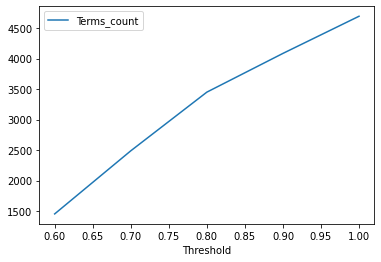

In [ ]:
input_files = ['termsdec_12_mapping_data_wiki_text_0.6.csv',
               'termsdec_12_mapping_data_wiki_text_0.7.csv',
               'termsdec_07_mapping_data_wiki_text_0.8.csv',
               'termsdec_12_mapping_data_wiki_text_0.9.csv',
               'termsdec_12_mapping_data_wiki_text_1.0.csv']

thresh_holds = [0.6, 0.7, 0.8, 0.9, 1.0]

data_dir = "../drive/"
terms_threshods = {}
terms_count = list()
for idx, file in enumerate(input_files):
  df = pd.read_csv(data_dir+file)
  terms_count.append(len(df))

print(terms_count)
d = {}
d['Threshold'] = thresh_holds
d['Terms_count'] = terms_count

df = pd.DataFrame(d, columns=['Threshold','Terms_count'])
df.plot.line(x='Threshold', y='Terms_count')